In [1]:
# Import relevant modules
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn
import sys  # Import sys for maxsize

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Settings
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)  # Use sys.maxsize instead of np.nan
np.set_printoptions(precision=3)
sns.set(style="darkgrid")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


In [2]:
train = pd.read_csv("Train_data.csv")
test = pd.read_csv("Test_data.csv")
train.head(-1)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.00,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.00,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.00,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.20,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.00,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25186,0,tcp,http,S1,339,14600,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,33,0.5,0.03,0.0,0.0,1.00,0.00,0.06,173,255,1.00,0.00,0.01,0.01,0.01,0.00,0.01,0.00,normal
25187,0,tcp,exec,RSTO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,7,0.0,0.00,1.0,1.0,0.07,0.07,0.00,255,7,0.03,0.06,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
25188,0,tcp,ftp_data,SF,334,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,1,39,1.00,0.00,1.00,0.18,0.00,0.00,0.00,0.00,anomaly
25189,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,105,7,0.0,0.00,1.0,1.0,0.07,0.07,0.00,255,13,0.05,0.07,0.00,0.00,0.00,0.00,1.00,1.00,anomaly


In [3]:
#'num_outbound_cmds' is a redundant column so remove it from both train & test datasets
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [4]:
# Attack Class Distribution
train['class'].value_counts()

class
normal     13449
anomaly    11743
Name: count, dtype: int64

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder



# **Initialize StandardScaler**
scaler = StandardScaler()

# **Extract numerical attributes**
num_cols = train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# **Apply StandardScaler Correctly**
sc_train = scaler.fit_transform(train[num_cols])  # Fit on train
sc_test = scaler.transform(test[num_cols])  # Transform on test

# **Convert scaled data back to DataFrame with same column names**
sc_traindf = pd.DataFrame(sc_train, columns=num_cols, index=train.index)
sc_testdf = pd.DataFrame(sc_test, columns=num_cols, index=test.index)

# **Initialize LabelEncoder Dictionary**
encoder_dict = {}  # Store encoders for each categorical column

# **Extract categorical attributes**
cat_cols = train.select_dtypes(include=['object']).columns.tolist()
if 'class' in cat_cols:
    cat_cols.remove('class')  # Remove target variable if it exists

# **Encode categorical attributes (train)**
train_encoded = pd.DataFrame(index=train.index)
test_encoded = pd.DataFrame(index=test.index)

for col in cat_cols:
    le = LabelEncoder()
    train_encoded[col] = le.fit_transform(train[col])  # Fit on train, transform train
    encoder_dict[col] = le  # Store encoder for test

    # **Transform test data using the same encoding**
    test_encoded[col] = test[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

# **Combine numerical & categorical features**
train_x = pd.concat([sc_traindf, train_encoded], axis=1)
test_x = pd.concat([sc_testdf, test_encoded], axis=1)

# **Separate target column (only for train data)**
train_y = train["class"]  # Target variable

# **Check final shape**
print("Train Shape:", train_x.shape)
print("Test Shape:", test_x.shape)


Train Shape: (25192, 40)
Test Shape: (22544, 40)


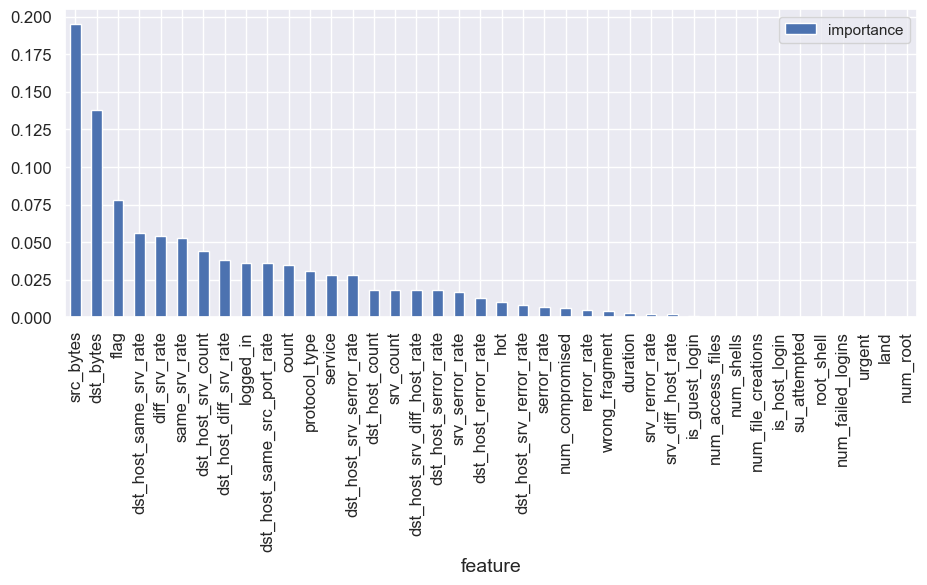

In [6]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(train_x, train_y);
# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_x.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [7]:
from sklearn.feature_selection import RFE
import itertools
rfc = RandomForestClassifier()

# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=15)
rfe = rfe.fit(train_x, train_y)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), train_x.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['src_bytes',
 'dst_bytes',
 'logged_in',
 'count',
 'srv_count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'protocol_type',
 'service',
 'flag']

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_x[selected_features], train_y, test_size=0.2, random_state=42)

In [10]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [24]:
X_train = np.array(X_train).astype(np.float32)
# y_train = np.array(y_train).astype(np.float32)

In [25]:
# Example mapping
label_map = {'normal': 0, 'anomaly': 1}

# Apply mapping if y_train is a list or pandas Series
y_train = [label_map[label] for label in y_train]
y_train = np.array(y_train).astype(np.float32)


In [28]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

# 2. Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=["accuracy"])


# 3. Fit the model
model.fit(X_train, y_train, epochs=100)


Epoch 1/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.9218 - loss: 0.2159
Epoch 2/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9595 - loss: 0.1188
Epoch 3/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9669 - loss: 0.0960
Epoch 4/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9690 - loss: 0.0857
Epoch 5/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9717 - loss: 0.0796
Epoch 6/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9728 - loss: 0.0766
Epoch 7/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9746 - loss: 0.0739
Epoch 8/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9757 - loss: 0.0693
Epoch 9/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9774 - loss: 0.0656
Epoch 10/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9770 - loss: 0.0661
Epoch 11/100
630/630 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9791 - loss: 0.0627
Epoch 12/100
630/630 ━━━━━━━━━━━━━━━━━━━

ImportError: The pyarrow installation is not built with support for the Parquet file format (DLL load failed while importing _parquet: The specified procedure could not be found.)

In [31]:
pip install datasets



  Using cached pyarrow-19.0.1-cp310-cp310-win_amd64.whl.metadata (3.4 kB)
Using cached pyarrow-19.0.1-cp310-cp310-win_amd64.whl (25.3 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.23.3
    Uninstalling huggingface-hub-0.23.3:
      Successfully uninstalled huggingface-hub-0.23.3


In [39]:
from datasets import load_dataset

ds = load_dataset("Console-AI/IT-helpdesk-synthetic-tickets")

ImportError: The pyarrow installation is not built with support for the Parquet file format (DLL load failed while importing _parquet: The specified procedure could not be found.)

In [37]:
pip uninstall pyarrow -y

Found existing installation: pyarrow 19.0.1
Uninstalling pyarrow-19.0.1:
  Successfully uninstalled pyarrow-19.0.1
Note: you may need to restart the kernel to use updated packages.


In [38]:
pip install pyarrow --upgrade

  Using cached pyarrow-19.0.1-cp310-cp310-win_amd64.whl.metadata (3.4 kB)
Using cached pyarrow-19.0.1-cp310-cp310-win_amd64.whl (25.3 MB)
Note: you may need to restart the kernel to use updated packages.
